# <font color=blus>Table of contents</font>

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu(first_level=1, last_level=4, header="Result issued from biais metrics")

# <font color=blus> Abstract</font>

    This notebook aims to expose biais preformances over CNN model built from notebook CNN_BinaryClassifier.
    
    1) Input data for validation is loaded. This data is issued from DataPreparator notebook.
    
    2) Model issued from CNN_binaryClassifier notebook is loaded and predictions are computed over validation dataset.
    
    3) Bias performance is computed using formula provided into kaggle Jigsaw https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview/evaluation
    

# <font color=blus> Software engineering</font>
<img src="./img/SoftwareEngineeringBiasMetrics.png">

In [1]:
from sklearn import metrics
%matplotlib inline

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [4]:
import p9_util

TOXICITY_COLUMN = p9_util.COLUMN_NAME_TARGET
TEXT_COLUMN = p9_util.COLUMN_NAME_DOC

# Create a text tokenizer.
#tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
#tokenizer.fit_on_texts(train_df[TEXT_COLUMN])

# All comments must be truncated or padded to be the same length.
MAX_SEQUENCE_LENGTH = 250
MODEL_NAME='predict'

# List all identities
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']


# <font color=blus> 1. Loading dataset</font>

    Dataset is extrcated from DataPreparator object for validation.
    Such object contains 
         * parameters used for building DataPreparator object
         * list of files saved on hard-disk for data validation.
         
     See DataPreparator.ipynb noteboo, for more details.

## <font color='blus'> 1.1 Load `DataPreparator` for validation</font>

In [7]:
import p5_util
filename = "./data/dataPreparator_valid_12000.dill"
if True:
    dataprep = p5_util.object_load(filename)
else :
    p5_util.object_dump(dataprep,filename)
self = dataprep


p5_util.object_load : fileName= ./data/dataPreparator_valid_12000.dill


In [8]:
self.list_df_data_file

['./data/df_dataprep_matrix_32.dill',
 './data/df_dataprep_matrix_82.dill',
 './data/df_dataprep_matrix_57.dill',
 './data/df_dataprep_matrix_122.dill',
 './data/df_dataprep_matrix_118.dill',
 './data/df_dataprep_matrix_86.dill',
 './data/df_dataprep_matrix_66.dill',
 './data/df_dataprep_matrix_52.dill',
 './data/df_dataprep_matrix_30.dill',
 './data/df_dataprep_matrix_79.dill',
 './data/df_dataprep_matrix_36.dill',
 './data/df_dataprep_matrix_109.dill']

    Once a file is loaded as a dataframe then original index column is added.
    
    This operation allows to join columns from original dataframe with 
    the dataframe columns issued from CNN model computation.
    

In [9]:
import pandas as pd
import p5_util

filename = self.list_df_data_file[0]
max_row = 20000
start_row = 0
self.df_data = pd.DataFrame()
for filename in self.list_df_data_file :
    
    df_data = p5_util.object_load(filename)
    end_row = start_row +len(df_data)
    
    if end_row > max_row :
        break
    else :
        self.df_data = pd.concat([self.df_data,df_data])
        start_row = end_row
    
self.df_data.reset_index(inplace=True)
self.df_data.rename(columns={'index':'original_index'}, inplace=True)
self.df_data.sample(3)

p5_util.object_load : fileName= ./data/df_dataprep_matrix_32.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_82.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_57.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_122.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_118.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_86.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_66.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_52.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_30.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_79.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_36.dill
p5_util.object_load : fileName= ./data/df_dataprep_matrix_109.dill


,original_index,docs,counting,tokens,matrix_padded,target
4046,587720,as long as the liberal media persist in charac...,11,"[long, liberal, medium, persist, characterize,...","[[0.28088000416755676, 0.21333999931812286, -0...",1
11401,1527293,"someone was a big stupid, lol here. the only ...",18,"[big, stupid, lol, way, bad, possible, weapon,...","[[-0.3789899945259094, 0.04135200008749962, -0...",1
7544,1107866,"and the suzuki foundation, sierra club, wwf,etc.",6,"[suzuki, foundation, sierra, club, wwf, etc]","[[0.6290900111198425, 0.7502400279045105, -0.3...",0


# <font color='blus'>2. Process to predictions</font>

## <font color='blus'> 2.1. Loading CNN model</font>

In [10]:
import keras

filename_model = './data/benchmark/model_jigsaw_submission_sample129651_threshold0.5_best_save.h5'
model = keras.models.load_model(filename_model)

model.summary()

W1027 11:48:16.266034 139965166282560 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1027 11:48:16.382707 139965166282560 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1027 11:48:16.384162 139965166282560 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1027 11:48:16.410959 139965166282560 deprecation_wrapper.py:119] From /home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 300)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 100, 300)          1200      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 256)          153856    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 20, 256)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 256)           1024      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 20, 256)           196864    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 4, 256)            0         
__________

    Make input data to be compliant for CNN model prediction.

In [12]:
import numpy as np

X = self.df_data.matrix_padded
#-----------------------------------------------------------------------
# Prepare input data in order to feed model prediction function : 
#    * Complete tuple of dimensions, out of 1st dimension.
#    * Compute shape for data feeding predictor.
#    * Initialize array with shape previously computed
#    * Transfer data into input
#-----------------------------------------------------------------------
list_tuple = list()
list_tuple.append(len(X))
for shape in X.iloc[0].shape:
    list_tuple.append(shape)

input_shape = tuple(i for i in list_tuple)
x_input = np.zeros(input_shape)

for item in range(len(X)):
    x_input[item]= X.values[item].copy()
input_model = x_input.copy()

    Make predictions and convert them into binary values.

In [16]:
self.df_data['predict'] = model.predict(input_model)[:,1]

In [18]:
import p9_util
self.df_data['predict'] = p9_util.convert_vectorFloat_2_binaryLabel(self.df_data['predict'].values, threshold=0.5, direction = 1, \
decimal_count = 1)

/home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


## <font color='blus'> 2.2 Load original dataset into df_train dataframe.</font>

In [1]:
import pandas as pd
import p5_util
df_train = pd.read_csv('./data/train.csv.zip', compression='zip', header=0, sep=',', quotechar='"')

### <font color='blus'>2.2.1. Build of df_identity dataframe.</font>

    For bias evaluation, df_identity dataframe is built from original dataframe.
    
    Columns from df_identity dataframe are required.
    
    Due to this, a join process between dataframe issued from CNN computation and df_identity 
    dataframe takes place.

In [20]:
identity_columns+['target','id']

['male',
 'female',
 'homosexual_gay_or_lesbian',
 'christian',
 'jewish',
 'muslim',
 'black',
 'white',
 'psychiatric_or_mental_illness',
 'target',
 'id']

In [22]:
#----------------------------------------------------------------------------
# Filter rows from original dataset with original indexes stored into 
# self.df_data
#----------------------------------------------------------------------------
filtered_index = self.df_data[p9_util.COLUMN_NAME_INDEX]

#----------------------------------------------------------------------------
# Apply filtered_index indexes over columns of df_indetity dataframe.
#----------------------------------------------------------------------------
df_identity = df_train.loc[filtered_index.values][identity_columns+['target','id']]

#----------------------------------------------------------------------------
# Reset indexes of df_identity dataframe;  new index column is renamed 
# original_index.
#----------------------------------------------------------------------------
df_identity.reset_index(inplace=True)


df_identity.rename(columns={'index':'original_index'}, inplace=True)
print(df_identity.columns)

Index(['original_index', 'male', 'female', 'homosexual_gay_or_lesbian',
       'christian', 'jewish', 'muslim', 'black', 'white',
       'psychiatric_or_mental_illness', 'target', 'id'],
      dtype='object')


    Save memory

In [37]:
del(df_train)

    Get 3 randoms rows from df_identity dataframe and let's check corresponding columns values
    do match with original dataset (df_train is the original dataset).
    
    Visual check is applied on columns id values for each dataframe.

In [23]:
arr_index = df_identity.original_index.sample(3).values
df_identity[df_identity['original_index'].isin(arr_index)]

,original_index,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,target,id
8674,1293094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,5695121
9546,144877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6,419218
11765,375631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,702894


In [24]:
df_train.loc[arr_index]

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
144877,419218,0.6,No one was punished for falsifying evidence be...,0.0,0.0,0.0,0.6,0.0,NaN,NaN,...,143071,approved,0,0,0,1,0,0.0,0,10
375631,702894,0.0,"Trudeau, Butts, McKenna, Wynne, Notley, and th...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,156250,approved,0,0,0,3,1,0.0,0,4
1293094,5695121,0.0,Why stop there? Enlightened colleges could als...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,361462,approved,1,0,0,1,0,0.0,0,4


    target column from df_identity dataframe is converted as a binary vector with same threshold 
    fixed for CNN model.  
    
    This way, model performance will be measure aagiant df_identity true values.

In [25]:
import p9_util
df_identity['target'] = p9_util.convert_vectorFloat_2_binaryLabel(df_identity['target'].values, threshold=0.5, direction = 1, \
decimal_count = 1)

/home/bangui/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


    Visual check over target column name.

In [26]:
df_identity[df_identity['original_index'].isin(arr_index)]

,original_index,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,target,id
8674,1293094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5695121
9546,144877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,419218
11765,375631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,702894


    Note below that true label values in target column are compared with predicted values in predict column.

In [27]:
self.df_data[self.df_data['original_index'].isin(arr_index)]

,original_index,docs,counting,tokens,matrix_padded,target,predict
8674,1293094,why stop there? enlightened colleges could als...,15,"[stop, enlighten, college, house, homeless, pr...","[[-0.05415000021457672, 0.13743999600410461, -...",0,0
9546,144877,no one was punished for falsifying evidence be...,37,"[punish, falsify, evidence, evidence, not, fal...","[[-0.8340499997138977, -0.15208999812602997, -...",1,0
11765,375631,"trudeau, butts, mckenna, wynne, notley, and th...",18,"[trudeau, butt, wynne, notley, rest, liberal, ...","[[-0.6492900252342224, 0.37839001417160034, -0...",0,0


    Join dataframe issued from data processing with identities dataframe.
    This join operation is based on original_index

In [28]:
df_identity = df_identity.join(self.df_data.set_index('original_index'), on='original_index', lsuffix='true_')

df_identity.columns

Index(['original_index', 'male', 'female', 'homosexual_gay_or_lesbian',
       'christian', 'jewish', 'muslim', 'black', 'white',
       'psychiatric_or_mental_illness', 'targettrue_', 'id', 'docs',
       'counting', 'tokens', 'matrix_padded', 'target', 'predict'],
      dtype='object')

    df_identity dataframe is now assigned with predict column, as shown on display below.

In [29]:
df_identity[df_identity['original_index'].isin(arr_index)]

,original_index,male,female,homosexual_gay_or_lesbian,christian,jewish,muslim,black,white,psychiatric_or_mental_illness,targettrue_,id,docs,counting,tokens,matrix_padded,target,predict
8674,1293094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,5695121,why stop there? enlightened colleges could als...,15,"[stop, enlighten, college, house, homeless, pr...","[[-0.05415000021457672, 0.13743999600410461, -...",0,0
9546,144877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,419218,no one was punished for falsifying evidence be...,37,"[punish, falsify, evidence, evidence, not, fal...","[[-0.8340499997138977, -0.15208999812602997, -...",1,0
11765,375631,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,702894,"trudeau, butts, mckenna, wynne, notley, and th...",18,"[trudeau, butt, wynne, notley, rest, liberal, ...","[[-0.6492900252342224, 0.37839001417160034, -0...",0,0


# <font color='blus'> 3.0 Bias metrics computation</font>

In [33]:
import numpy as np
threshold = dict_param_benchmark['threshold']
print(threshold)
for identity in identity_columns :
    df_identity[identity] = np.where(df_identity[identity] > threshold, True, False)

0.5


In [34]:
import p9_util_metrics

bias_metrics_df = p9_util_metrics.compute_bias_metrics_for_model(df_identity, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc,subgroup_size
2,0.837397,0.669649,homosexual_gay_or_lesbian,0.645546,149
6,0.880691,0.641463,black,0.661654,199
7,0.888992,0.652551,white,0.680226,335
5,0.867801,0.713312,muslim,0.719677,222
8,0.917395,0.727446,psychiatric_or_mental_illness,0.784848,43
0,0.852952,0.810845,male,0.802190,356
1,0.853437,0.821859,female,0.813832,404
4,0.838606,0.852951,jewish,0.831250,68
3,0.841626,0.851564,christian,0.832449,269


In [35]:
overall_auc = p9_util_metrics.calculate_overall_auc(df_identity, MODEL_NAME, p9_util_metrics.TOXICITY_COLUMN)
overall_auc

0.8601040799111624

In [36]:
p9_util_metrics.get_final_metric(bias_metrics_df, overall_auc)

Bias score contribution : 0.5792517283787755


0.7942777483565661

# <font color='blus'> 4.0 Binary classification performances</font>

    Load data generator objects for train and validation.

In [2]:
import p5_util

filename_train = './data/train_generator.dill'
filename_valid = './data/valid_generator.dill'

train_generator = p5_util.object_load(filename_train)
valid_generator = p5_util.object_load(filename_valid)


p5_util.object_load : fileName= ./data/train_generator.dill
p5_util.object_load : fileName= ./data/valid_generator.dill


    Extract digitalized data from datagenerator sources to feed model as input.

In [3]:
import numpy as np

X_valid = valid_generator.X
y_valid = valid_generator.y
y_valid =y_valid.astype(int)

    Load trained CNN model issued from CNN_BinaryClassifier notebook.

In [7]:
import keras

filename_model = './data/benchmark/model_jigsaw_submission_sample129651_threshold0.5_best_save.h5'
model = keras.models.load_model(filename_model)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100, 300)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 100, 300)          1200      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 256)          153856    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 20, 256)           0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 20, 256)           1024      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 20, 256)           196864    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 4, 256)            0         
__________

    Apply predictions over validation dataset.

In [5]:
import numpy as np

y_predict = model.predict(X_valid, verbose=1)
y_predict_round = np.round(y_predict).astype(int)

12000/12000 [==============================] - 10s 858us/step


    Display CNN model performances 

/home/bangui/.local/lib/python3.6/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/bangui/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[0, 1]

Confusion matrix for all classes : 

[[5267  925]
 [ 755 5053]]

Normalized confusion matrix
[[0.8506137  0.1493863 ]
 [0.12999311 0.87000689]]
Confusion matrix, without normalization
[[5267  925]
 [ 755 5053]]

TP rate = [0.         0.87000689 1.        ]
FP rate = [0.        0.1493863 1.       ]
AUC = 0.8603102910713905


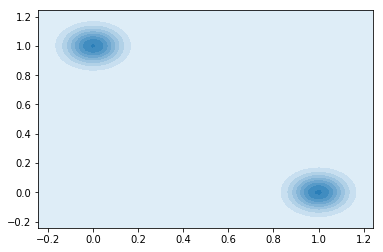

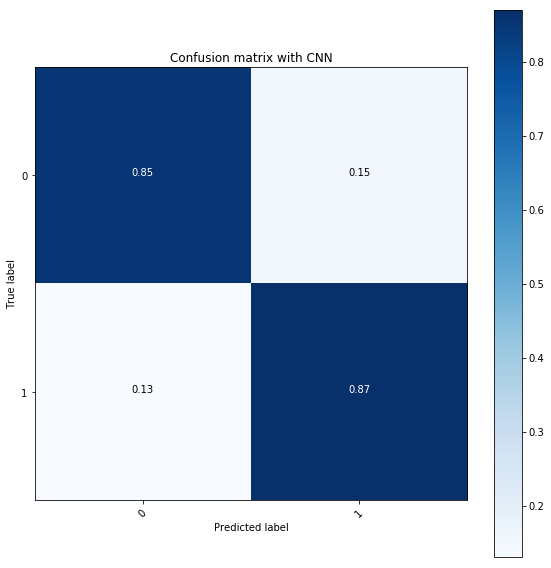

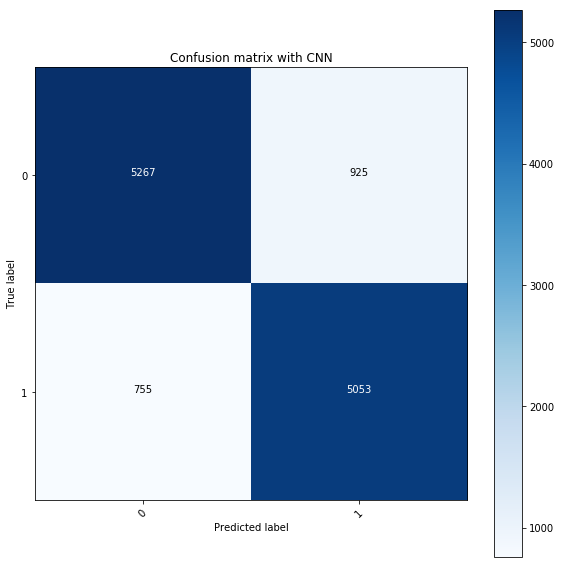

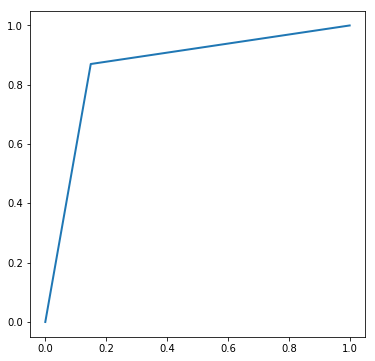

In [6]:
import p9_util

y_= p9_util.display_class_performance(model, X_valid, y_valid, is_binary=True, \
                                      y_pred=y_predict_round, \
                                      title="Confusion matrix with CNN")